In [2]:
# local imports
import glob
from importlib import reload
from my_ddsp_utils import *
import ddsp
import ddsp.training

import tensorflow.compat.v1 as tf
print("tf versionn: ",tf.__version__)
# tf.compat.v1.enable_v2_behavior()
import tensorflow_datasets as tfds

import time
import tensorflow_datasets as tfds


tf versionn:  2.1.0


### Build tfrecords! 

In [3]:
input_audio_filepatterns = "./Data/piano/piano30s.wav"
output_tfrecord_path = './Data/piano/piano30s.tfrecord'
train_file_pattern = output_tfrecord_path+"*"

input_audio_filepatterns

if not glob.glob(input_audio_filepatterns):
    raise ValueError('No audio files found. Please use the previous cell to '
                    'upload.')
else:
    print("found", input_audio_filepatterns)

!ddsp_prepare_tfrecord \
  --input_audio_filepatterns=$input_audio_filepatterns \
  --output_tfrecord_path=$output_tfrecord_path \
  --num_shards=10 \
  --alsologtostderr

found ./Data/piano/piano30s.wav
Instructions for updating:
non-resource variables are not supported in the long term
I0219 02:16:22.407964 4528076224 fn_api_runner_transforms.py:490] ==================== <function annotate_downstream_side_inputs at 0x7fbfa200a620> ====================
I0219 02:16:22.408634 4528076224 fn_api_runner_transforms.py:490] ==================== <function fix_side_input_pcoll_coders at 0x7fbfa200a730> ====================
I0219 02:16:22.409061 4528076224 fn_api_runner_transforms.py:490] ==================== <function lift_combiners at 0x7fbfa200a7b8> ====================
I0219 02:16:22.409200 4528076224 fn_api_runner_transforms.py:490] ==================== <function expand_sdf at 0x7fbfa200a840> ====================
I0219 02:16:22.409456 4528076224 fn_api_runner_transforms.py:490] ==================== <function expand_gbk at 0x7fbfa200a8c8> ====================
I0219 02:16:22.409881 4528076224 fn_api_runner_transforms.py:490] ==================== <function sink

### build dataset by reading tfrecords!

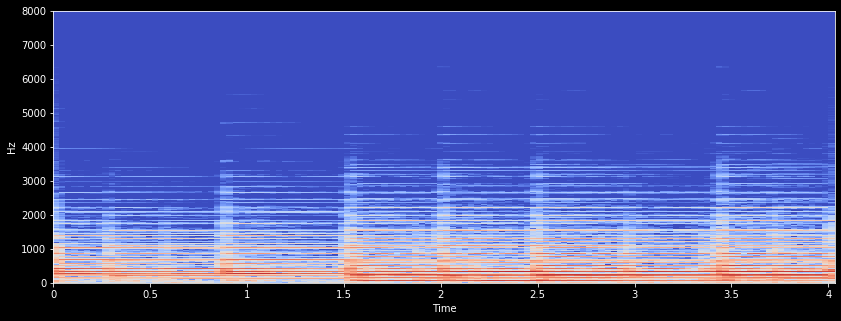

In [191]:
# Get a single example from NSynth.
# Takes a few seconds to load from GCS.
data_provider = ddsp.training.data.TFRecordProvider(train_file_pattern)
dataset = data_provider.get_batch(batch_size=1, shuffle=False).take(1).repeat()

# sample = next(iter(dataset))
# audio = sample['audio']
# n_samples = audio.shape[1]

samples = list(iter(data_provider.get_dataset(shuffle=False)))
sample_num = 20
sample = samples[sample_num]
audio = sample["audio"]
n_samples = audio.shape[0]

specPlot(audio)
play(audio)

### Define Model

In [111]:
# get distribution strategy (change if using gpus/tpus)
strategy = ddsp.training.train_util.get_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [112]:
TIME_STEPS = 1000

# Create Neural Networks.
preprocessor = preprocessing.DefaultPreprocessor(time_steps=TIME_STEPS)

decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                rnn_type = 'gru',
                                ch = 256,
                                layers_per_stack = 1,
                                output_splits = (('amps', 1),
                                                 ('harmonic_distribution', 45),
                                                 ('noise_magnitudes', 45)))

# Create Processors.
additive = ddsp.synths.Additive(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='additive')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(additive, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'additive/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                 name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

with strategy.scope():
    # Put it together in a model.
    model = models.Autoencoder(preprocessor=preprocessor,
                             encoder=None,
                             decoder=decoder,
                             processor_group=processor_group,
                             losses=[spectral_loss])
    trainer = ddsp.training.train_util.Trainer(model, strategy, learning_rate=1e-3)

In [113]:
# Build model, easiest to just run forward pass.
dataset = trainer.distribute_dataset(dataset)
trainer.build(next(iter(dataset)))

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectral_loss (SpectralLoss) multiple                  0         
_________________________________________________________________
rnn_fc_decoder (RnnFcDecoder multiple                  814171    
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
Total params: 814,171
Trainable params: 814,171
Non-trainable params: 0
_________________________________________________________________


###  Train

In [114]:
dataset_iter = iter(dataset)

In [177]:
iterations = 50
for i in range(iterations):
    losses = trainer.train_step(dataset_iter)
    res_str = 'step: {}\t'.format(i)
    for k, v in losses.items():
        res_str += '{}: {:.2f}\t'.format(k, v)
        print(res_str)

step: 0	spectral_loss: 6.70	
step: 0	spectral_loss: 6.70	total_loss: 6.70	
step: 1	spectral_loss: 6.72	
step: 1	spectral_loss: 6.72	total_loss: 6.72	
step: 2	spectral_loss: 6.78	
step: 2	spectral_loss: 6.78	total_loss: 6.78	
step: 3	spectral_loss: 6.89	
step: 3	spectral_loss: 6.89	total_loss: 6.89	
step: 4	spectral_loss: 6.78	
step: 4	spectral_loss: 6.78	total_loss: 6.78	
step: 5	spectral_loss: 6.70	
step: 5	spectral_loss: 6.70	total_loss: 6.70	
step: 6	spectral_loss: 6.70	
step: 6	spectral_loss: 6.70	total_loss: 6.70	
step: 7	spectral_loss: 6.70	
step: 7	spectral_loss: 6.70	total_loss: 6.70	
step: 8	spectral_loss: 6.69	
step: 8	spectral_loss: 6.69	total_loss: 6.69	
step: 9	spectral_loss: 6.67	
step: 9	spectral_loss: 6.67	total_loss: 6.67	
step: 10	spectral_loss: 6.66	
step: 10	spectral_loss: 6.66	total_loss: 6.66	
step: 11	spectral_loss: 6.68	
step: 11	spectral_loss: 6.68	total_loss: 6.68	
step: 12	spectral_loss: 6.66	
step: 12	spectral_loss: 6.66	total_loss: 6.66	
step: 13	spectral_l

### Analyze

In [178]:
samples = list(iter(data_provider.get_dataset(shuffle=False)))
sample_num = 20
sample = samples[sample_num]
audio = sample["audio"]

In [179]:
# Run a batch of predictions.
start_time = time.time()
controls =  model.get_controls(sample)
audio_gen = controls['processor_group']['signal']
print('Prediction took %.1f seconds' % (time.time() - start_time))

Prediction took 0.9 seconds


Original Audio


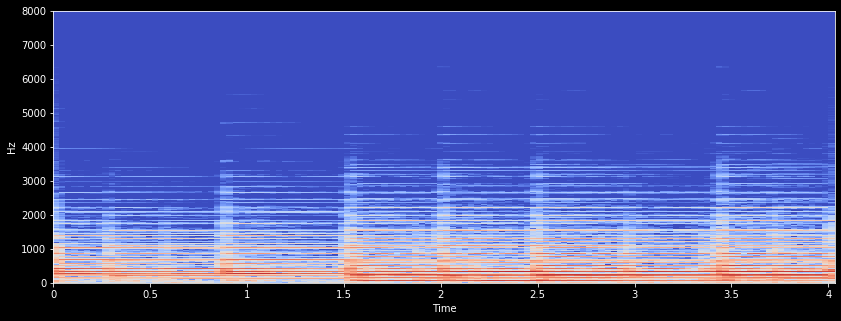

In [180]:
print('Original Audio')
specPlot(audio)
play(audio)

Resynthesized Audio


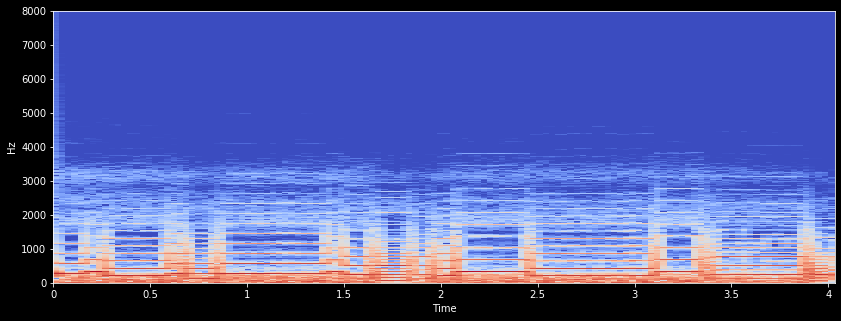

In [181]:
print('Resynthesized Audio')
specPlot(audio_gen)
play(audio_gen)

Filtered Noise Audio


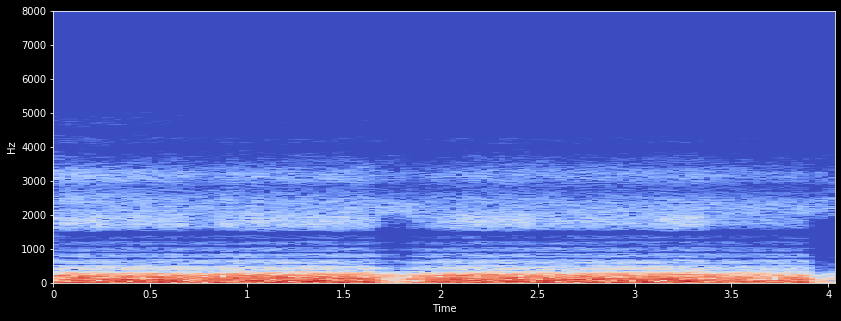

In [182]:
print('Filtered Noise Audio')
audio_noise = controls['noise']['signal']
specPlot(audio_noise)
play(audio_noise)